# Final Project

Our idea is find out what the Public opinion is on Twitter on the overturning of Roe v. Wade in large city’s in the US  and to investigate whether it corresponds with the laws in that state.

### Retrieving and storing Twitter data

First, we will import the Tweepy API, which we can use to retrieve tweets. We applied for Academic Research access, so we could retrieve more t to search for tweets around the time Roe V Wade overturned and to check the location of the tweet.

In [1]:
import tweepy

CONSUMER_KEY = 'pttmAvuj8z26khmI29Iy6Yvkt'
CONSUMER_SECRET = 'AxWg9dcVVFX1K9TrLUiecXBqpSZn4lu1qEJvIlAoWRRUDd9F9x'
OAUTH_TOKEN = '1364492577957965825-3Curg3S5QShUpIa3YcF7VpHJTGzSkT'
OAUTH_TOKEN_SECRET = 'md1dtliBClGRem1MDUpLMoCm4GtKXbkMsx54sZAeDpRNU'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAN29jwEAAAAA83MuicQ7VEXm9VY%2F68ZZ%2BGVht9I%3DAkULEZI8WPV44znUF6pVf0D8MHazsz2xh8jsq2I5UH9PCPxds7'

client = tweepy.Client(bearer_token)

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True)

We created a function to add new lines to files. We will create two files, one containing the tweets and the second containing the location.

In [2]:
def append_new_line(file_name, text_to_append):
    with open(file_name, "a+") as file_object:
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        file_object.write(text_to_append)

Here we specify the query, we want to find tweets containing the hashtag #RoeVwade. Furthermore we specify that the tweet is not a retweet and the country where the tweet has been posted is in the US. The timeframe we collect tweets is 5 days before Roe V. Wade overturned and five days after. Since there is a limit of tweets you can collect, we store the tweets and locations immeditately in a file. We included a sleep time to make sure we would not receive a too many request error. 

We can skip this code if we collected all tweets and locations in the files

In [3]:
#import time
#query = '#RoeVWade -is:retweet place_country:US'

#start_time = '2022-06-19T00:00:00Z'
#end_time = '2022-06-29T00:00:00Z'

#limit is 100
#for i in range(1500):
    #max_result=100

    #tweets = client.search_all_tweets(query=query, tweet_fields=['context_annotations', 'created_at', 'geo'],
    #                                  place_fields=['place_type', 'geo'], expansions='geo.place_id', 
    #                                  start_time=start_time, end_time=end_time, max_results=max_result)

    # Get list of places from includes object
    #places = {p["id"]: p for p in tweets.includes['places']}

    #for tweet in tweets.data:
        #text = tweet.text
        #if places[tweet.geo['place_id']]:
            #place = places[tweet.geo['place_id']]
            #place = place.full_name
        #text_to_append = (text + ': ' + place)
        #append_new_line('tweets.txt', text)
        #append_new_line('locations.txt', place)
    #time.sleep(2)

Here we merge the two files into one dataframe consisting of a column of tweets and a column with locations.

In [4]:
import pandas as pd

df1 = pd.read_csv('tweets.txt', sep='\t', header=None, names=['Tweet'])
df2 = pd.read_csv('locations.txt', sep='\t', header=None, names=['Location'])


df = pd.concat([df1, df2], axis=1, join='inner')
print(len(df))
display(df.head(5))


150000


Tweet        Location
0  Democratic senators need to shut up and come u...  Wisconsin, USA
1  Overturning #RoeVWade is a public health crisi...   Cleveland, OH
2  SIGN NOW -&gt; Demand Congress stand up immedi...   Delaware, USA
3                  #RoeVWade https://t.co/VYMtMZVuHH    Evendale, OH
4  This days it all. #RoeVWade https://t.co/JvMFK...    Lea Hill, WA

### Clean Location

We retrieve the location from the tweets metadata, however, it is not always in the form we want. Overall the form is 'city', 'state abbreviation'. Lets start with splitting the location values into two columns. 

We focus on the second column, containing the state abbreviation. When looking at the unique values from that column below, we see that some values do not have the state abbreviation, but instead USA or None. Before continuing with our project we would like to clean this. In the end we want one column with only the state abbrevation.

In [5]:
df[['First','Last']] = df.Location.str.split(",",expand=True,)
df['Last'] = df['Last'].str.strip()

In [6]:
print(df.Last.unique())

['USA' 'OH' 'WA' 'MO' 'MN' 'GA' 'NY' 'CO' 'NV' 'MS' 'MI' None 'IN' 'LA'
 'TX' 'OR' 'DC' 'CA' 'NE' 'IA' 'SC' 'PA' 'MA' 'Philadelphia' 'NC' 'TN'
 'FL' 'Puerto Rico' 'HI' 'OK' 'AL' 'NJ']


We replace Philadelphia with the state it belongs to and we remove Puerto Rico.

In [7]:
import numpy as np

#Puerto Rico is part of the USA, but for simplicity we only use the states. 
df.drop(df.loc[df['Last']=='Puerto Rico'].index, inplace=True)

#We change philadelphia into the state it belongs to
df.loc[df["Last"] == 'Philadelphia', "Last"] = 'PA'

Some rows contain the value USA instead of the state abbreviation. Lets see what is in the first column when this happens. Below we see it happens for wisconsin, delaware, new york, colorado, kansas, florida, indiana and maine. These are all states, so we will loop through the rows and replace USA with the correct state abbreviation.

In [8]:
df2=df.loc[df['Last'] == 'USA', 'First']
df2.unique()

array(['Wisconsin', 'Delaware', 'New York', 'Colorado', 'Kansas',
       'Florida', 'Indiana', 'Maine'], dtype=object)

In [9]:
state_to_abbrev = {
    "Wisconsin": "WI",
    "Delaware": "DE",
    "New York": "NY",
    "Colorado": "CO",
    "Kansas": "KS",
    "Florida": "FL",
    "Indiana": "IN",
    "Maine": "ME"}


for i, row in df.iterrows():
    if row.Last == 'USA':
        df.at[i, 'Last'] = state_to_abbrev[row.First]

df.head(5)

Tweet        Location  \
0  Democratic senators need to shut up and come u...  Wisconsin, USA   
1  Overturning #RoeVWade is a public health crisi...   Cleveland, OH   
2  SIGN NOW -&gt; Demand Congress stand up immedi...   Delaware, USA   
3                  #RoeVWade https://t.co/VYMtMZVuHH    Evendale, OH   
4  This days it all. #RoeVWade https://t.co/JvMFK...    Lea Hill, WA   

       First Last  
0  Wisconsin   WI  
1  Cleveland   OH  
2   Delaware   DE  
3   Evendale   OH  
4   Lea Hill   WA

Now we focus on the None column, lets check what is in the first column when this happens. Below we see it happens for specific places, and the fast food place McDonald's.

In [10]:
df2=df.loc[df['Last'].isna(), 'First']
df2.unique()

array(['Downtown Springfield', 'Washington Square Park',
       'Fountains of Bellagio', "McDonald's"], dtype=object)

In [11]:
clean_dict = {
    "Downtown Springfield": "MO",
    "Washington Square Park": "NY",
    "Fountains of Bellagio": "NV"}

for i, row in df.iterrows():
    value = row['Last']
    if pd.isnull(value) and row.First != "McDonald's":
        df.at[i, 'Last'] = clean_dict[row.First]
    if pd.isnull(value) and row.First == "McDonald's":
        df.drop(i, inplace=True)


Lets see how many rows we have left. Wow a lot of the tweets were located in Mcdonalds. I wonder why the Mcdonalds is stored in the metadata instead of the actual location.

In [12]:
print(len(df))

146940


In [13]:
final_df = df[['Tweet', 'Last']].copy()
final_df.rename(columns={'Last':'Location'}, inplace=True)

final_df.head(5)

Tweet Location
0  Democratic senators need to shut up and come u...       WI
1  Overturning #RoeVWade is a public health crisi...       OH
2  SIGN NOW -&gt; Demand Congress stand up immedi...       DE
3                  #RoeVWade https://t.co/VYMtMZVuHH       OH
4  This days it all. #RoeVWade https://t.co/JvMFK...       WA

# TO DO

- i think it is interesting to investigate the spread of the location of the tweets, thus how many tweets per state. I stored the state as the abbreviation, but we could also store it as the whole name if that is easier, idk. Maybe make a nice graph. Something like this (https://www.geo-social.com/blogs/Jonathan_poster_2022.pdf) here they use colors to represent each state in a map, we could also do this for the spread of the tweets (and later also for the sentiment)

- below we have some code for cleaning the twitter data and making the wordcloud, i did not test this yet with the new dataframe, so maybe some things need to be changed. And it would be interesting to compare some of the states (maybe the ones with the most tweets) and see if the wordclouds look a like

- after cleaning the tweets we could start measuring the sentiment of the tweets per state. 

### Investigate spread of the tweets

### Cleaning Twitter data

To clean the twitter data we perform multiple steps. We remove links from the tweets, we remove punctuation, tokenize the tweet and remove stopwords.

In [14]:
import string
import nltk
stopword = nltk.corpus.stopwords.words('english')

def remove_link(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

def remove_punct(tweet):
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', '', tweet)
    return tweet

def tokenization(tweet):
    tweet = re.split('\W+', tweet)
    return tweet

def remove_stopwords(tweet):
    tweet = [word for word in tweet if word not in stopword]
    return tweet

In [15]:
import re
cleaned_tweets = []
for tweet in final_df['Tweet']:
    tweet = remove_stopwords(tokenization(remove_punct(remove_link(tweet.lower()))))
    tweet = list(filter(None, tweet))
    cleaned_tweets.append(tweet)

# cleaned_tweets[:10]

In [16]:
final_df['Tweet'][final_df['Location'] == 'NY'].count()

13775

In [17]:
pop = final_df.groupby(['Location'])['Location'].count().reset_index(
    name='Count').sort_values(['Count'], ascending=False)

pop.head(5)

Location  Count
1        CA  16834
5        FL  16830
22       NY  13775
16       MO   9188
2        CO   9185

CA



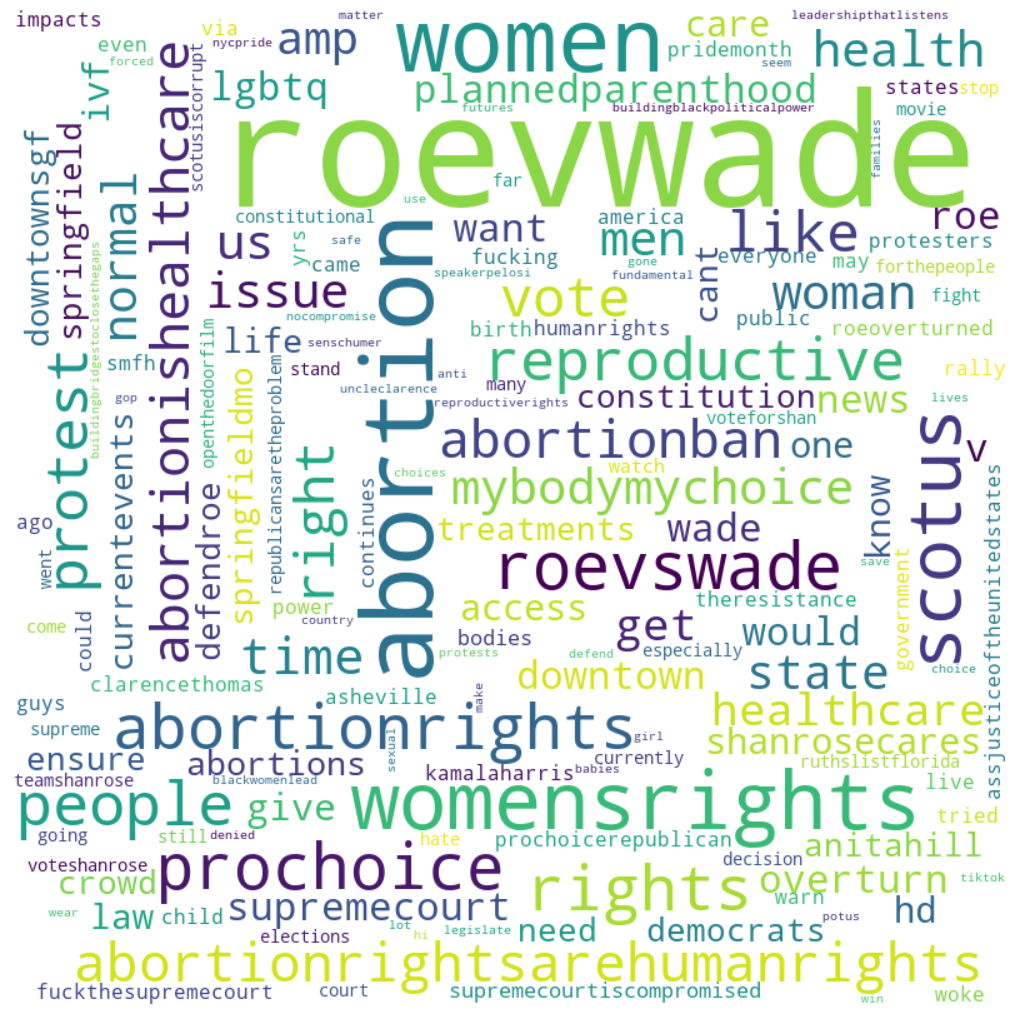

FL



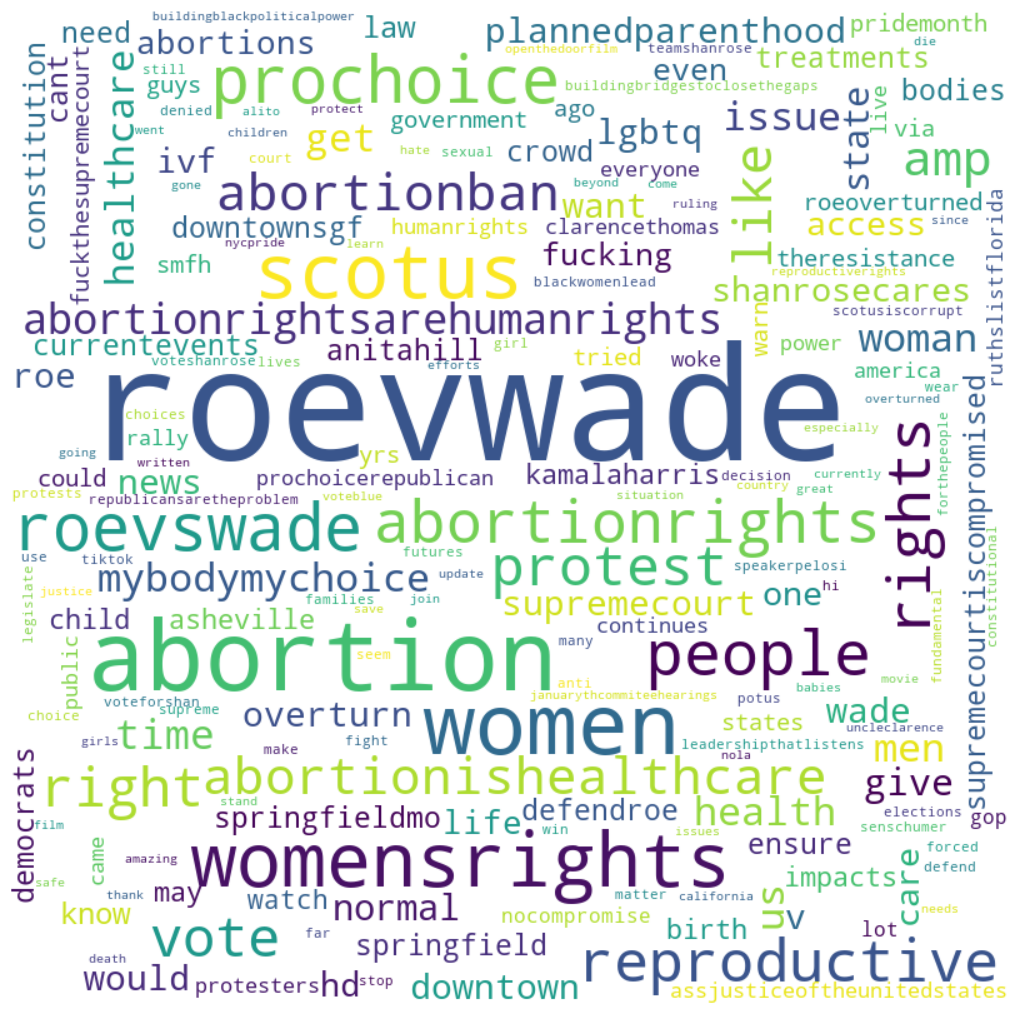

NY



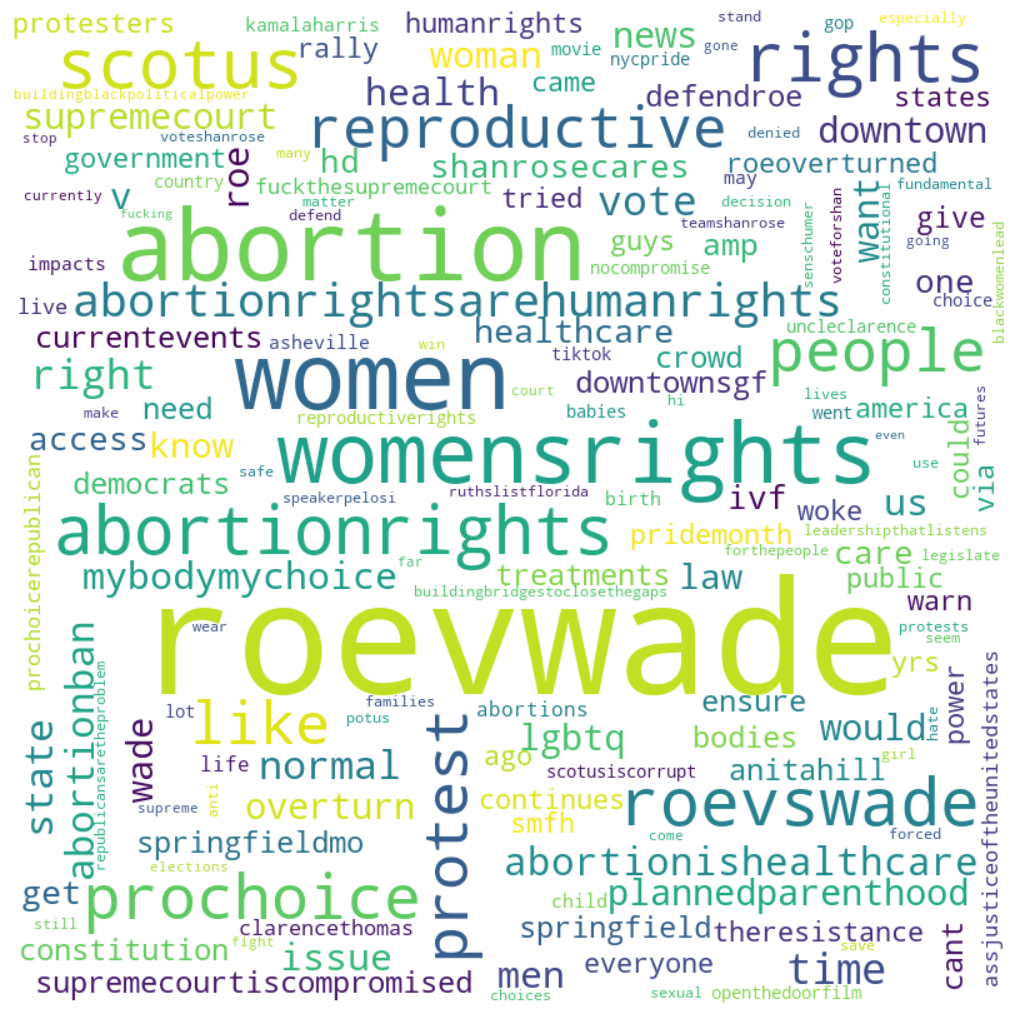

MO



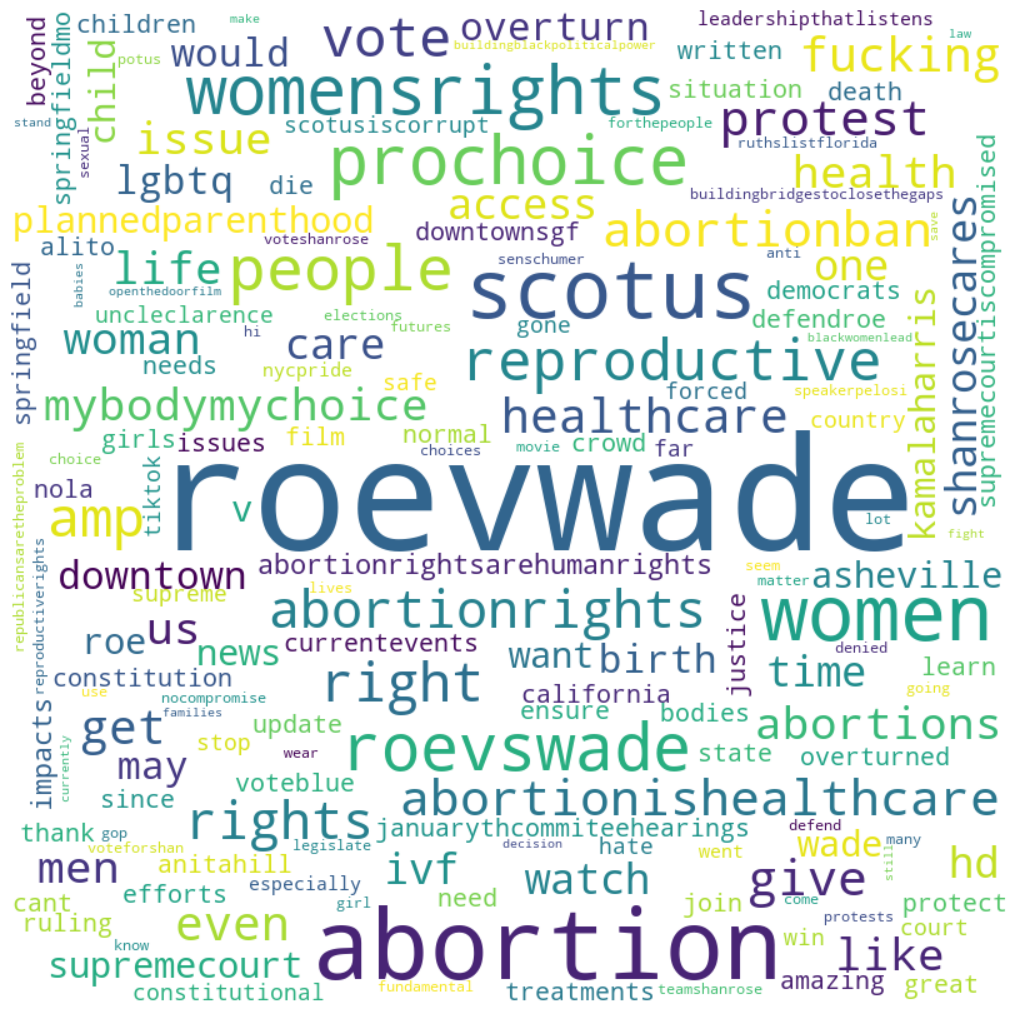

CO



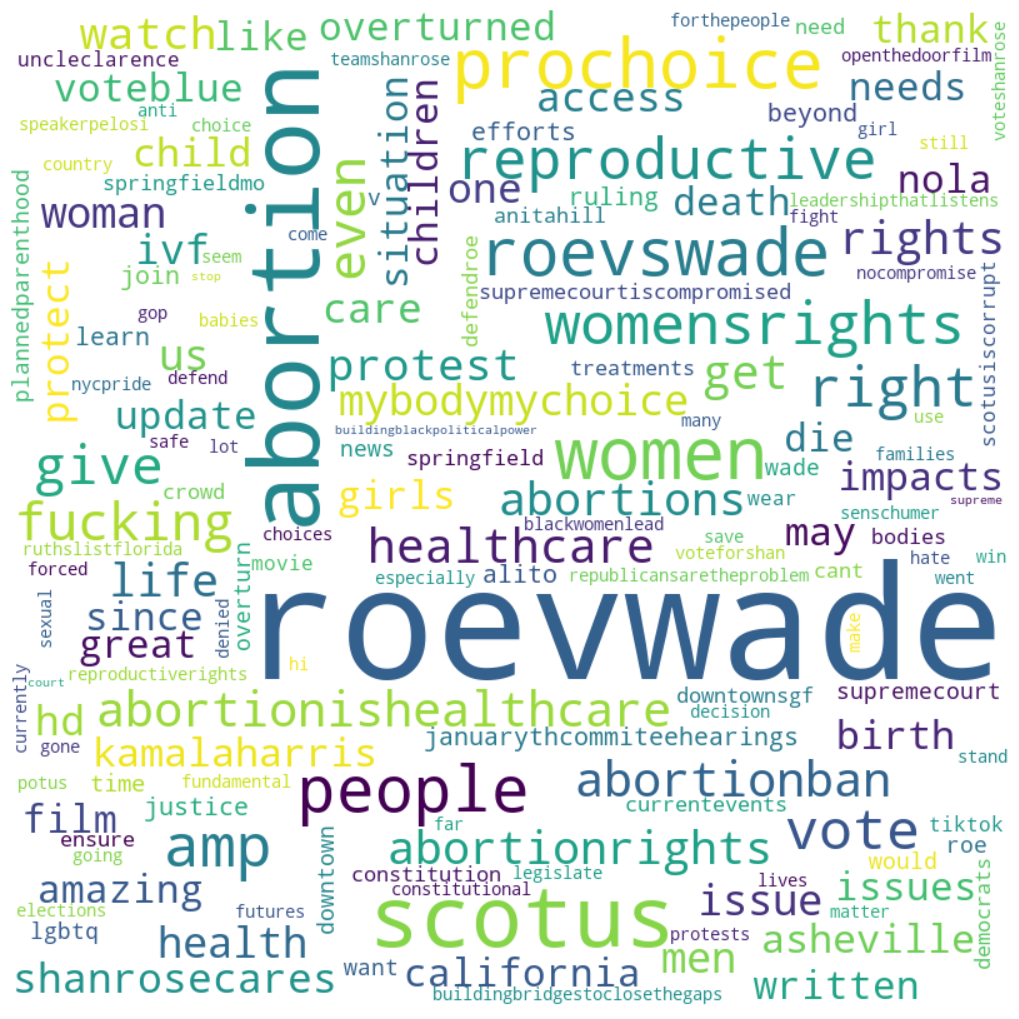

In [18]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

c = ['CA','FL','NY','MO','CO']

for l in c:
    
    print('\033[1m'+l+'\033[0m')
    print()

    cleaned_tweets = []
    for tweet in final_df['Tweet'][final_df['Location'] == l]:
        tweet = remove_stopwords(tokenization(remove_punct(remove_link(tweet.lower()))))
        tweet = list(filter(None, tweet))
        cleaned_tweets.append(tweet)

    total = Counter()
    for i in cleaned_tweets[0:]:
            total.update(i)


    dict(total)

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate_from_frequencies(total)

    # plot the WordCloud image
    plt.figure(figsize = (15, 10), facecolor = None) 
    plt.imshow(wordcloud,interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

In [19]:
import numpy as np

ar = final_df.Location.unique()
print(np.sort(ar))

['AL' 'CA' 'CO' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'IN' 'KS' 'LA' 'MA' 'ME'
 'MI' 'MN' 'MO' 'MS' 'NC' 'NE' 'NJ' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'SC'
 'TN' 'TX' 'WA' 'WI']


In [20]:
final_df1 = final_df.assign(label='')

In [21]:
banned = ['AL','LA','MS','MO','TN','TX','WV','WI']
limit = ['FL','IA','GA','NC','IN','OH','MI']

final_df1.loc[final_df1['Location'].isin(banned),'label'] = 'banned'
final_df1.loc[final_df1['Location'].isin(limit),'label'] = 'limit'
final_df1.loc[final_df1['label'] == '','label'] = 'legal'

In [22]:
final_df1

Tweet Location   label
0       Democratic senators need to shut up and come u...       WI  banned
1       Overturning #RoeVWade is a public health crisi...       OH   limit
2       SIGN NOW -&gt; Demand Congress stand up immedi...       DE   legal
3                       #RoeVWade https://t.co/VYMtMZVuHH       OH   limit
4       This days it all. #RoeVWade https://t.co/JvMFK...       WA   legal
...                                                   ...      ...     ...
149995  I may seem okay, but I get randomly choked up/...       MN   legal
149996  @myrnamelgar Constitutional scholar Myrna Melg...       MO  banned
149997  All Out for Abortion Rights! in Downtown Sprin...       MO  banned
149998                                                  .       CO   legal
149999                                          6/24/2022       MN   legal

[146940 rows x 3 columns]

In [27]:
df = final_df1
df

0         banned
1          limit
2          legal
3          limit
4          legal
           ...  
149995     legal
149996    banned
149997    banned
149998     legal
149999     legal
Name: label, Length: 146940, dtype: object

In [31]:
!pip3 install -U scikit-learn

     |████████████████████████████████| 8.6MB 5.7MB/s eta 0:00:01
     |████████████████████████████████| 34.2MB 31.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/61/cf/6e354304bcb9c6413c4e02a747b600061c21d38ba51e7e544ac7bc66aecc/threadpoolctl-3.1.0-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


y = df['label']
x = df

X_train, X_test, y_train, y_test  = train_test_split(x,y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
#print(X_test.groupby('category').size())


X_test = X_test.drop(['label'],axis=1)

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


X_test.columns = X_test.columns.str.strip()
X_train.columns = X_train.columns.str.strip()

X_test=X_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)


In [39]:
from nltk.tokenize import word_tokenize,WordPunctTokenizer
from nltk.corpus import stopwords

#test set tokenization

test_lowercase = []
clean_test_words = []
clean_test_words_str = []
tokenizer = WordPunctTokenizer()
for word in X_test['Tweet']:
    test_lowercase.append(tokenizer.tokenize(word.lower()))

stop_words = set(stopwords.words('english'))

i=0
for x in range(0,len(test_lowercase)):
    
    clean_test_words.append([token for token in test_lowercase[x] if not token in stop_words and token.isalpha()])
    clean_test_words_str.append(" ".join(clean_test_words[i]))
    i+=1

In [40]:
#train set tokenization

lowercase = []
clean_words = []
clean_words_str = []
tokenizer = WordPunctTokenizer()
for word in X_train['Tweet']:
    lowercase.append(tokenizer.tokenize(word.lower()))

stop_words = set(stopwords.words('english'))

i=0
for x in range(0,len(lowercase)):
    
    clean_words.append([token for token in lowercase[x] if not token in stop_words and token.isalpha()])
    clean_words_str.append(" ".join(clean_words[i]))
    i+=1

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=100, sublinear_tf=True, min_df=7) 
tfidf = tfidf_vectorizer.fit_transform(clean_words_str)

tfidf_test = tfidf_vectorizer.transform(clean_test_words_str)


In [45]:
X = tfidf.toarray()
X_te = tfidf_test.toarray()

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create the parameter grid based on the results of random search 
param_grid = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, scoring = 'accuracy')

clf.fit(X, y_train)
print(clf.best_params_)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

{'max_depth': 10, 'max_features': 1}


In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(max_depth = 10, max_features= 3)
clf.fit(X, y_train)
Y_pred = clf.predict(X_te) 

confusion_matrix(y_test,Y_pred) 
print(classification_report(y_test,Y_pred))

acc = cross_val_score(clf, X,y_train,scoring="accuracy", cv=10)

accuracy_score(y_test, Y_pred)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5817
           1       0.53      1.00      0.69     15613
           2       0.00      0.00      0.00      7958

    accuracy                           0.53     29388
   macro avg       0.18      0.33      0.23     29388
weighted avg       0.28      0.53      0.37     29388



0.5312712671838846

In [53]:
print(acc)

[0.53130316 0.53130316 0.53126329 0.53126329 0.53126329 0.53126329
 0.53126329 0.53126329 0.53126329 0.53126329]
